In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
import os
import random
from matplotlib.lines import Line2D
import colorsys
from matplotlib import colors
import readFiles

# Matplotlib rc parameters modification

plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
#plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

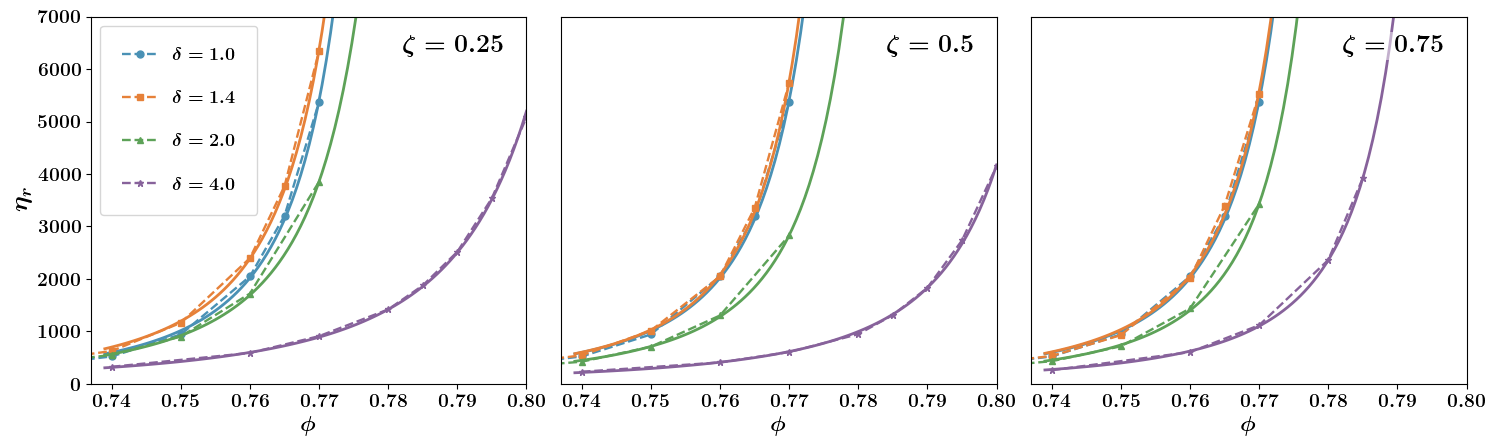

In [3]:
# maron pierce all plots

#### NEW DATA #####

from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
from IPython.display import display, Math, HTML
warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

def maronpierce(x,c,k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Prevent negative or zero base
    return 1 * (base ** -c)

#cmap = matplotlib.colormaps['viridis_r'] #color scheme
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
line_markers = ['o', 's', '^', '*', 'p']

#mac
# topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
# fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/paper/'

# #linux
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
# fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/paper_figs/'

# Parameters
npp     = 1000
phiv    = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82]
arr     = [1.0, 1.4, 2.0, 4.0]
vrr     = ['0.25', '0.5', '0.75']
numRuns = 2
off     = 100
phim    = []
cvals   = []
k_guess = [[.785,.785,.792,0.82],
           [.785,.785,.792,0.815],
           [.785,.785,.792,0.8]]
           # initial guess for max phi (phim)

fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

for i, vri in enumerate(vrr):
    rerr    = [] # r2 error
    phims    = [] # max phi calculated from fitting
    c_list  = []
    for j, arj in enumerate(arr):
        visc = []
        for k, phi in enumerate(phiv):
            phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            visc_list = []
            for run in range(numRuns):
                vrj = '0.25' if arj == 1 else vri
                workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrj}/run_{run+1}/"
                if os.path.exists(workDir):
                    #print(workDir)
                    dataFile = glob.glob(workDir+"data_*.dat")[0]
                    data     = np.loadtxt(dataFile)
                    visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
            visc.append(np.mean(visc_list) if visc_list else np.nan) 

        visc_filtered     = [x for x in visc if not np.isnan(x)]
        phi_vals_filtered = [y for x, y in zip(visc, phiv) if not np.isnan(x)]

        # curve fit
        popt, pcov   = curve_fit(maronpierce, phi_vals_filtered,visc_filtered,[1,k_guess[i][j]])
        c_opt, k_opt = popt
        phims.append(k_opt)
        ax[i].plot(phi_vals_filtered, visc_filtered,linestyle='--',marker=line_markers[j], 
                   #label=r'$\delta = {:.1f}$ ($\phi_m = {:.3f}$)'.format(arj,k_opt), 
                   label=r'$\delta = {:.1f}$'.format(arj,k_opt), 
                   color=colors[j],linewidth=1.7)
        #print(f"Optimal value for c (del = {arj:.1f}): {c_opt:.4f}")
        c_list.append(c_opt)

        # plotting for model
        xx = np.linspace(0.739, .80, 100)
        yy = maronpierce(xx,c_opt,k_opt)
        ax[i].plot(xx, yy, color = colors[j], linewidth=2)
            
    phim.append(phims)
    cvals.append(c_list)
    
    #ax[i].grid(which='Both', alpha=0.2)
    ax[i].set_xlim(.737, .80)
    ax[i].set_ylim(0, 7000)
    ax[i].set_xlabel(r'$\phi$', fontsize=16,fontstyle='italic')
    ax[i].tick_params(axis='x', labelsize=14)
    ax[0].legend(loc='upper left', fontsize=13, labelspacing=1.5, borderpad=1.2)
    #ax[i].set_title(fr'$\gamma = {vrr[i]}$', fontsize=13, pad=10)
    ax[i].text(0.95, 0.95, fr'$\zeta = {vrr[i]}$', 
               fontsize=18,
               ha='right', va='top',            # Align text to top-right
               transform=ax[i].transAxes,       # Use axes coordinates (0-1)
               bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))

# plot parameters
ax[0].set_ylabel(r'$\eta_{r}$', fontsize=18,fontstyle='italic')
ax[0].tick_params(axis='y', labelsize=14)
ax[1].set_yticks([])
ax[2].set_yticks([])

fig.tight_layout()

figsave=False
if figsave:
    figFormat=".pdf"
    plt.savefig(fig_save_path+ 'Maron_Pierce_fit'+figFormat, bbox_inches="tight",dpi=500)

plt.show()

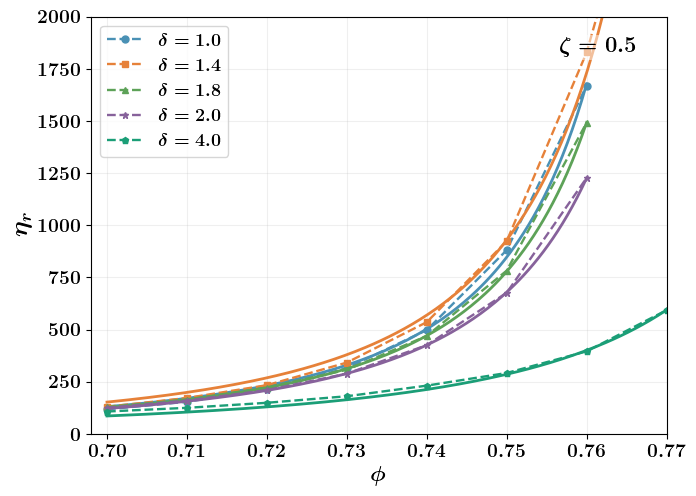

[0.787707908604828,
 0.7929207079793926,
 0.7893201348065644,
 0.7930994916062075,
 0.8248959336128324]

In [38]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings

warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

def maronpierce(x, c, k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Prevent negative or zero base
    return base ** -c

# Directories and parameters
topDir = '/media/rahul/rahul_2TB/high_bidispersity/old_data/'
npp = 1000
phiv = [0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.79, 0.8, 0.792]
arr = [1.0, 1.4, 1.8, 2.0, 4.0]
vrr = '0.5'
numRuns = 4
off = 100
k_guess = [0.787, 0.792, 0.7893, 0.7930, 0.824]

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
line_markers = ['o', 's', '^', '*', 'p']

# Prepare plot
fig, ax = plt.subplots(figsize=(7, 5))

phims = []
c_list = []

for j, arj in enumerate(arr):
    visc = []
    for phi in phiv:
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        visc_list = []
        for run in range(numRuns):
            workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrr}/run_{run+1}/"
            if os.path.exists(workDir):
                dataFile = glob.glob(workDir + "data_*.dat")[0]
                data = np.loadtxt(dataFile)
                if len(data[off:, 3]) > 0:
                    visc_list.append(np.mean(data[off:, 3]))
        visc.append(np.mean(visc_list) if visc_list else np.nan)

    visc_filtered = [x for x in visc if not np.isnan(x)]
    phi_vals_filtered = [y for x, y in zip(visc, phiv) if not np.isnan(x)]

    # Fit curve
    popt, pcov = curve_fit(maronpierce, phi_vals_filtered, visc_filtered, [1, k_guess[j]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    # Plot data points
    ax.plot(phi_vals_filtered, visc_filtered,
            linestyle='--', marker=line_markers[j],
            label=fr'$\delta = {arj:.1f}$', color=colors[j], linewidth=1.7)

    # Plot fit
    xx = np.linspace(min(phi_vals_filtered), max(phi_vals_filtered), 200)
    yy = maronpierce(xx, c_opt, k_opt)
    ax.plot(xx, yy, color=colors[j], linewidth=2)

# Final touches
ax.set_xlim(0.698, 0.77)
ax.set_ylim(0, 2000)
ax.set_xlabel(r'$\phi$', fontsize=16)
ax.set_ylabel(r'$\eta_r$', fontsize=18)
ax.tick_params(axis='both', labelsize=14)
ax.legend(loc='upper left', fontsize=13)
ax.text(0.95, 0.95, fr'$\zeta = {vrr}$',
        fontsize=16, ha='right', va='top',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))
ax.grid(True, which='both', alpha=0.2)
fig.tight_layout()

# Save plot if needed
figsave = False
if figsave:
    figFormat = ".pdf"
    fig_save_path = '/your/path/here/'
    plt.savefig(fig_save_path + 'Maron_Pierce_fit' + figFormat, bbox_inches="tight", dpi=500)

plt.show()

phims

In [17]:
phim_new = [[0.7886717028827888, 0.7894387136954615, 0.793926329607985, 0.8308426789537554],
            [0.7886717028827888, 0.7877885526918533, 0.7939236898756902, 0.8239196866554372],
            [0.7886717028827888, 0.7885308930400247, 0.7900830006913417, 0.8044291017153138]]

cvals_new = [[2.2961534930915994, 2.3650311285005365, 2.3581023842731605, 2.597868196804314],
             [2.2961534930915994, 2.2844228427617583, 2.2697625367992815, 2.355255703134564],
             [2.2961534930915994, 2.3000699722687648, 2.217088555299523, 2.2226341715514715]]

In [39]:
phim_old = [0.787707908604828,
 0.7929207079793926,
 0.7893201348065644,
 0.7930994916062075,
 0.8248959336128324]
cvals_old = [2.2182170855364416, 2.3436324953765584, 2.2194856137177132, 2.2389127875226844, 2.356880545693027]

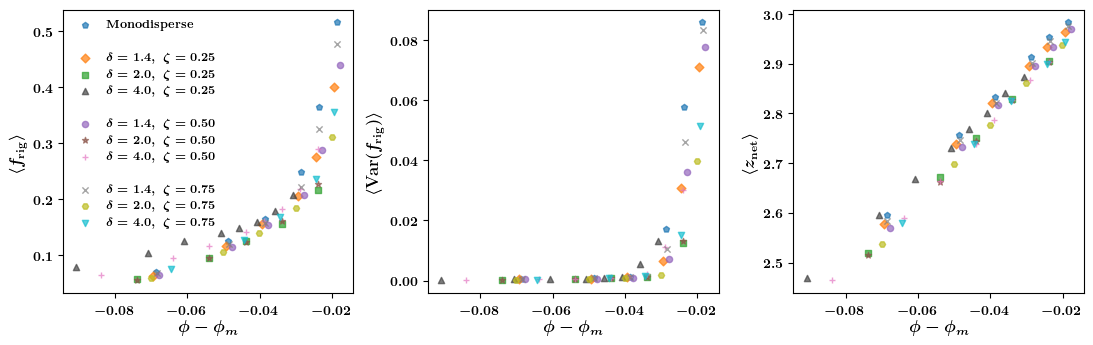

In [34]:
# import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
import matplotlib.patches as patches
    
#linux
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ising/'

# Parameters
npp          = 1000
phiv         = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
arr          = [1.4, 2.0, 4.0] # 1.0 is a seperate case
vrr          = ['0.25', '0.5', '0.75']
numRuns      = 2
off          = 100
pcount       = 0
totParams    = 2 # total plots
ncols        = 2
nrows        = int(totParams/ ncols)
colors       = ['#1f77b4', '#ff7f0e', '#2ca02c', '#444444',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                '#bcbd22', '#17becf', '#f6a821', '#f6d020',
                '#003366', '#cc6699']
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']
ylables      = [ r'$f_{rig}$', r'$\langle Z_{{net}} \rangle$']

phimall      = []
param        = []
paramserr    = []
zm = []
fig, ax= plt.subplots(1, 3, figsize=(11,3.5))

## plotting ar = 1 and vr = 0.25 case first
for k, phi in enumerate(phiv):
    phir           = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    param_list     = []
    paramserr_list = []
    zlist =[]
    for run in range(numRuns):
        phim_vals = [(i -  phim_new[0][0]) for i in phiv]
        workDir   = f"{topDir}NP_{npp}/phi_{phir}/ar_1.0/Vr_0.25/run_{run+1}/"
        
        if os.path.exists(workDir):
            frigFile = workDir + "F_rig.txt"
            frig     = np.loadtxt(frigFile)/ npp

            znetFile = workDir+"Z_Znet.txt"
            znet     = np.loadtxt(znetFile)[:, 2]
            
            param_list.append(np.mean(frig[off:]) if len(frig) > off else None)
            paramserr_list.append(np.var(frig[off:]) if len(frig) > off else None)
            zlist.append(np.mean(znet[off:]))
            
    param.append(np.mean(param_list) if param_list else np.nan)
    paramserr.append(np.mean(paramserr_list) if paramserr_list else np.nan)
    zm.append(np.nanmean(zlist) if zlist else np.nan)
    
param_filtered     = [x for x in param if not np.isnan(x)]
paramerr_filtered  = [x for x in paramserr if not np.isnan(x)]
phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
z_filtered         = [x for x in zm if not np.isnan(x)]

ax[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount], 
              s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')
ax[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount], 
              s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')
ax[2].scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount], 
              s=20, color=colors[pcount], alpha=0.7, label=r'$\textbf{Monodisperse}$')  
              
pcount += 1
ax[0].plot([], [], ' ', label=" ") 
ax[1].plot([], [], ' ', label=" ")

# plotting other cases
for l, vrl in enumerate(vrr):
    for j, arj in enumerate(arr):
        param     = []
        paramserr = []
        zm = []
        for k, phi in enumerate(phiv):
            phir           = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            param_list     = []
            paramserr_list = []
            zlist = []
            for run in range(numRuns):
                phim_vals     = [(i - phim_new[l][j+1]) for i in phiv]
                workDir       = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrl}/run_{run+1}/"
                frigFile = workDir+"F_rig.txt"
                if os.path.exists(frigFile):
                    frigFile = workDir+"F_rig.txt"
                    frig     = np.loadtxt(frigFile)/ npp

                    znetFile = workDir+"Z_Znet.txt"
                    znet     = np.loadtxt(znetFile)[:, 2]
                    
                    if len(frig) > off:
                        param_list.append(np.mean(frig[off:]))
                        paramserr_list.append(np.var(frig[off:]))
                        zlist.append(np.mean(znet[off:]))
                    else:
                        param_list.append(np.nan)
                        paramserr_list.append(np.nan)
                        zlist.append(np.nan)
                        
            # Average over runs for this phi
            param.append(np.nanmean(param_list) if param_list else np.nan)
            paramserr.append(np.nanmean(paramserr_list) if paramserr_list else np.nan)
            zm.append(np.nanmean(zlist) if zlist else np.nan)
            
        # Clean up for plotting
        param_filtered     = [x for x in param if not np.isnan(x)]
        paramerr_filtered  = [x for x in paramserr if not np.isnan(x)]
        phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
        z_filtered         = [x for x in zm if not np.isnan(x)]
        
        ax[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount], 
                      s=20, color=colors[pcount], alpha=0.7,  
                      label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')
        ax[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount], 
                      s=20, color=colors[pcount], alpha=0.7,  
                      label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')
        ax[2].scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount], 
                      s=20, color=colors[pcount], alpha=0.7,  
                      label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$')    
        
        pcount += 1

    ax[0].plot([], [], ' ', label=" ") 
    ax[1].plot([], [], ' ', label=" ") 

labelfont = 12
tickfont  = 10  # You can adjust this as needed

for ax_i in ax:
    ax_i.tick_params(axis='both', labelsize=tickfont)

ax[0].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[0].set_ylabel(r'$\langle f_{\mathrm{rig}} \rangle$', fontsize=labelfont)

ax[1].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[1].set_ylabel(r'$\langle \mathrm{Var}(f_{\mathrm{rig}}) \rangle$', fontsize=labelfont)
#ax[1].set_yscale('log')

ax[2].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[2].set_ylabel(r'$\langle z_{\mathrm{net}} \rangle$', fontsize=labelfont)

ax[0].legend(loc='upper left', fontsize=8.5, frameon=False, labelspacing=0.5)

fig.tight_layout()

if True:
    figFormat=".pdf"
    plt.savefig(fig_save_path+'frig_znet_plot_new_data'+figFormat, bbox_inches="tight",dpi=800)

plt.show()

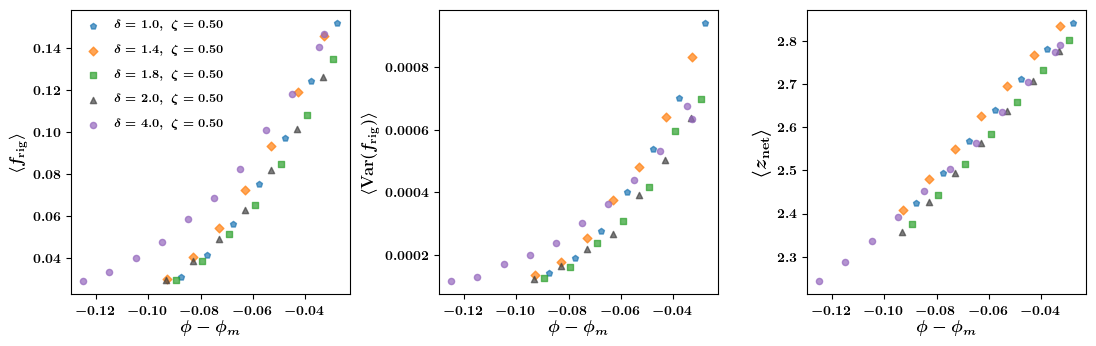

In [40]:
# import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
import matplotlib.patches as patches
    
#linux
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/old_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ising/'

# Parameters
npp          = 1000
phiv         = [0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.79, 0.8, 0.792]
arr          = [1.0, 1.4, 1.8, 2.0, 4.0]
vrr          = '0.5'
numRuns      = 4
off          = 100
pcount       = 0
totParams    = 2 # total plots
ncols        = 2
nrows        = int(totParams/ ncols)
colors       = ['#1f77b4', '#ff7f0e', '#2ca02c', '#444444',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                '#bcbd22', '#17becf', '#f6a821', '#f6d020',
                '#003366', '#cc6699']
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']
ylables      = [ r'$f_{rig}$', r'$\langle Z_{{net}} \rangle$']

phimall      = []
param        = []
paramserr    = []
zm           = []
fig, ax      = plt.subplots(1, 3, figsize=(11,3.5))

# plotting other cases

for j, arj in enumerate(arr):
    param     = []
    paramserr = []
    zm = []
    for k, phi in enumerate(phiv):
        phir           = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        param_list     = []
        paramserr_list = []
        zlist = []
        for run in range(numRuns):
            phim_vals     = [(i - phim_old[j]) for i in phiv]
            workDir       = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrr}/run_{run+1}/"
            frigFile = workDir+"F_rig.txt"
            znetFile = workDir+"Z_Znet.txt"
            
            if os.path.exists(frigFile) and os.path.exists(znetFile):
                frig = np.loadtxt(frigFile)/ npp
                znet = np.loadtxt(znetFile)[:, 2]
                
                if len(frig) > off:
                    param_list.append(np.mean(frig[off:]))
                    paramserr_list.append(np.var(frig[off:]))
                    zlist.append(np.mean(znet[off:]))
                else:
                    param_list.append(np.nan)
                    paramserr_list.append(np.nan)
                    zlist.append(np.nan)
                    
        # Average over runs for this phi
        param.append(np.nanmean(param_list) if param_list else np.nan)
        paramserr.append(np.nanmean(paramserr_list) if paramserr_list else np.nan)
        zm.append(np.nanmean(zlist) if zlist else np.nan)
        
    # Clean up for plotting
    param_filtered     = [x for x in param if not np.isnan(x)]
    paramerr_filtered  = [x for x in paramserr if not np.isnan(x)]
    phim_vals_filtered = [y for x, y in zip(param, phim_vals) if not np.isnan(x)]
    z_filtered         = [x for x in zm if not np.isnan(x)]
    
    ax[0].scatter(phim_vals_filtered, param_filtered, marker=marker_shape[pcount], 
                  s=20, color=colors[pcount], alpha=0.7,  
                  label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrr):.2f}$')
    ax[1].scatter(phim_vals_filtered, paramerr_filtered, marker=marker_shape[pcount], 
                  s=20, color=colors[pcount], alpha=0.7,  
                  label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrr):.2f}$')
    ax[2].scatter(phim_vals_filtered, z_filtered, marker=marker_shape[pcount], 
                  s=20, color=colors[pcount], alpha=0.7,  
                  label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrr):.2f}$')    
    
    pcount += 1

ax[0].plot([], [], ' ', label=" ") 
ax[1].plot([], [], ' ', label=" ") 
    
labelfont = 12
tickfont  = 10  # You can adjust this as needed

for ax_i in ax:
    ax_i.tick_params(axis='both', labelsize=tickfont)

ax[0].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[0].set_ylabel(r'$\langle f_{\mathrm{rig}} \rangle$', fontsize=labelfont)

ax[1].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[1].set_ylabel(r'$\langle \mathrm{Var}(f_{\mathrm{rig}}) \rangle$', fontsize=labelfont)
#ax[1].set_yscale('log')

ax[2].set_xlabel(r'$\phi - \phi_m$', fontsize=labelfont)
ax[2].set_ylabel(r'$\langle z_{\mathrm{net}} \rangle$', fontsize=labelfont+2)

ax[0].legend(loc='upper left', fontsize=8.5, frameon=False, labelspacing=1.2)

#fig.tight_layout()

if True:
    figFormat=".pdf"
    plt.savefig(fig_save_path+'frig_znet_plot_old_data'+figFormat, bbox_inches="tight",dpi=800)

plt.show()